In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import casadi as ca
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from acados_template import AcadosOcp, AcadosOcpSolver, AcadosModel

In [2]:
class UnconstrOptimizer:
    def __init__(self):

        self.func_flag = 'quadratic'

        self.x_init = np.array([0.0, 0.0])

        self.solution_trajectory = []
        self.directions = []

        self.x = ca.MX.sym('x', 2)
        
        # Hyperparameters for line search
        self.alpha_0 = 1.0
        self.beta = 0.5
        self.c = 1e-4

    def set_objective(self, func_type='quadratic'):
        self.func_flag = func_type

        if func_type == 'quadratic':
            expr = 0.5 * (self.x[0]**2/4 + self.x[1]**2)
            self.global_minima = np.array([0.0, 0.0])

        elif func_type == 'rosenbrock':
            expr = (1 - self.x[0])**2 + 100*(self.x[1] - self.x[0]**2)**2
            self.global_minima = np.array([1.0, 1.0])

        elif func_type == 'rastrigin':
            expr = 20 + (self.x[0]**2 - 10*ca.cos(2*np.pi*self.x[0])) + (self.x[1]**2 - 10*ca.cos(2*np.pi*self.x[1]))
            self.global_minima = np.array([0.0, 0.0])

        else:
            raise ValueError("Unknown function type.")

        self.expr = expr
        self.f = ca.Function('f', [self.x], [expr])
        self.grad_f = ca.Function('grad_f', [self.x], [ca.gradient(expr, self.x)])
        self.hess_f = ca.Function('hess_f', [self.x], [ca.hessian(expr, self.x)[0]])

    def solve(self, x_init, method='gd', max_step=100, tol=1e-6):

        self.x_init = np.array(x_init, dtype=np.float64)
        self.method = method
        self.tol = tol
        self.max_step = max_step

        self.solution_trajectory = [self.x_init.copy()]
        self.directions = []

        # Unconstrained optimization
        x_val = np.copy(self.x_init)

        for _ in range(self.max_step):
            grad = self.grad_f(x_val).full().flatten()
            hess = self.hess_f(x_val).full()

            # Search direction
            if self.method == 'gd':
                direction = -grad
            elif self.method == 'newton':
                direction = -np.linalg.solve(hess + 1e-8*np.eye(2), grad)
            else:
                raise ValueError("Method must be 'gd' or 'newton'")

            descent = grad @ direction
            if abs(descent) < self.tol:
                break

            # Line search (backtracking)
            alpha = self.alpha_0
            f0 = float(self.f(x_val))
            while float(self.f(x_val + alpha * direction)) > f0 + self.c * alpha * descent:
                alpha *= self.beta
            
            # Update
            x_val = x_val + alpha * direction
            self.solution_trajectory.append(x_val.copy())
            self.directions.append(direction.copy())

    def plot_results(self):

        sol = np.array(self.solution_trajectory)

        x_max = max(5, np.max(sol[:,0]))
        x_min = min(-5, np.min(sol[:,0]))
        y_max = max(5, np.max(sol[:,1]))
        y_min = min(-5, np.min(sol[:,1]))

        x = np.linspace(x_min, x_max, 400)
        y = np.linspace(y_min, y_max, 400)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)

        fig, ax = plt.subplots(figsize=(10,8))
        
        # Plot global optima
        ax.plot(self.global_minima[0], self.global_minima[1], marker='*', markersize=15, color='red', label='Global Optima')

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i,j] = self.f(np.array([X[i,j], Y[i,j]])).full().flatten()[0]

        CS = ax.contourf(X, Y, Z, levels=100, cmap=cm.viridis, alpha=0.8)
        plt.colorbar(CS, ax=ax, label='Cost')

        ax.plot(sol[:,0], sol[:,1], marker='o', markersize=4, color='orange', label='Trajectory')
        ax.plot(sol[0,0], sol[0,1], 'bo', label='Start')
        ax.plot(sol[-1,0], sol[-1,1], 'gs', label='End')

        ax.set_title(f'Optimization Trajectory with {self.func_flag.capitalize()} Function')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.legend()
        plt.grid(True)
        plt.show()

Unconstrained case: 

key idea: 
1) GD for quadratic (performance baseline)
2) GD for rosenbrock (limitation of GD)
3) Newton for rosenbrock (Newton outperform GD in searching direction)
4) GD & Newton for Rastrigin (limitation of non-convex function -> only local attractive)

cost: quadratic + Rosenbrock + Rastrigin

method: hand written GD/Newton + line search

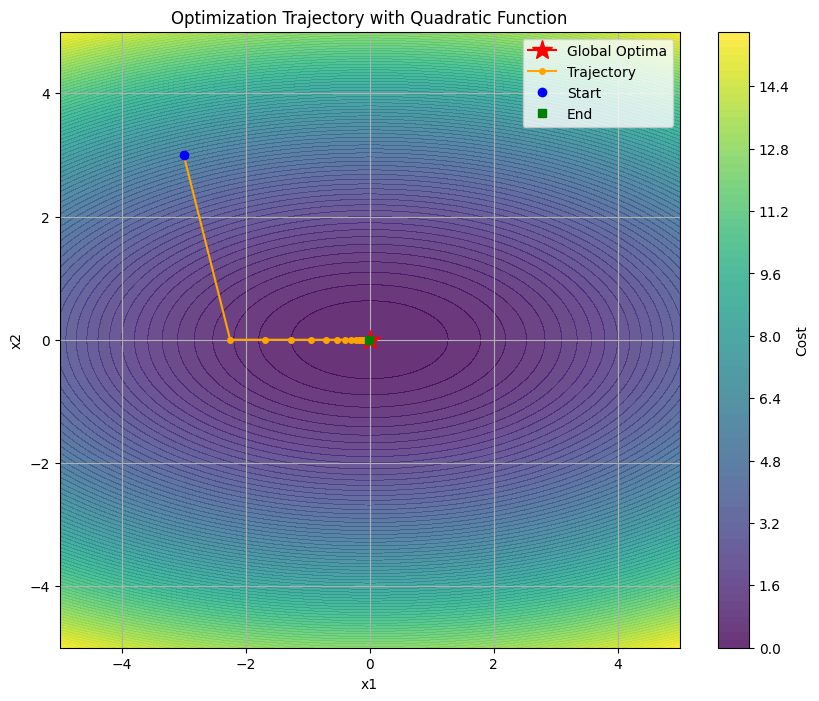

In [3]:
# Quadratic cost + GD solver
opt = UnconstrOptimizer()
opt.set_objective('quadratic')
opt.solve(x_init=[-3, 3], method='gd', max_step=100)
opt.plot_results()


Conclusion: for simple case (quadratic -> convex), GD is able to find global optima and quite fast

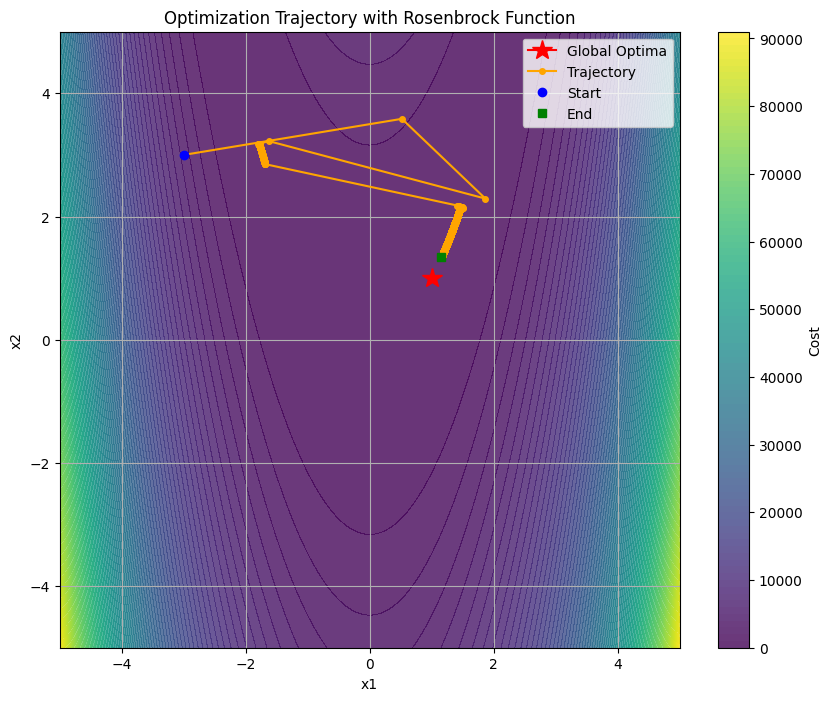

In [4]:
# Rosenbrock cost + GD solver
opt = UnconstrOptimizer()
opt.set_objective('rosenbrock')
opt.solve(x_init=[-3.0, 3.0], method='gd', max_step=3000) 
opt.plot_results()

Conclusion: for complexer case (Rosenbrock->ill-conditioning), GD is still able to find the global optima, but 3000~5000 steps & zig-zag

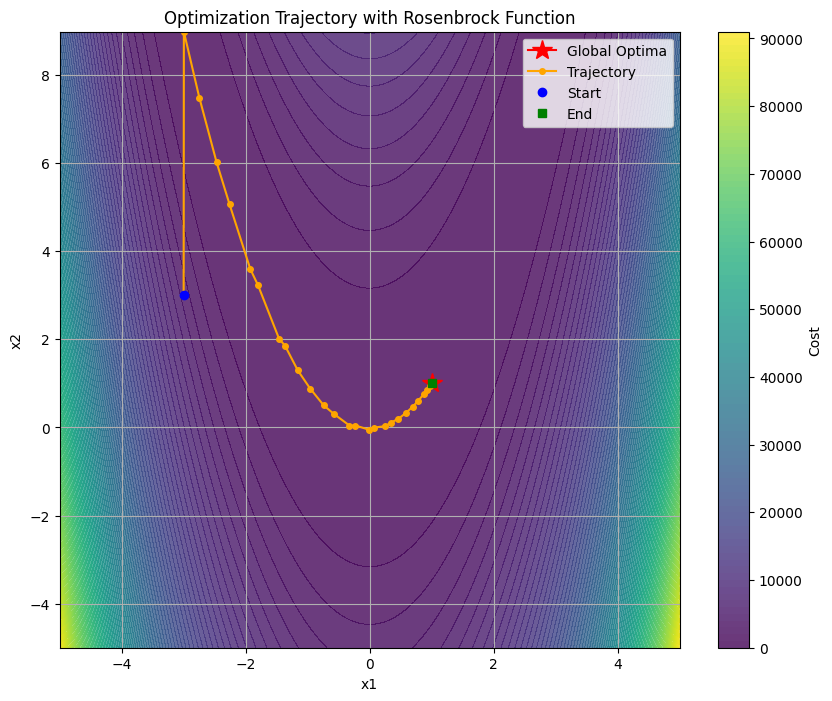

In [5]:
# Rosenbrock cost + newton solver
opt = UnconstrOptimizer()
opt.set_objective('rosenbrock')
opt.solve(x_init=[-3, 3], method='newton', max_step=100)
opt.plot_results()


Conclusion: able to find the global optima & much faster that GD (<100 steps)   
Deeper insight: more info (in coop. with curvature information)

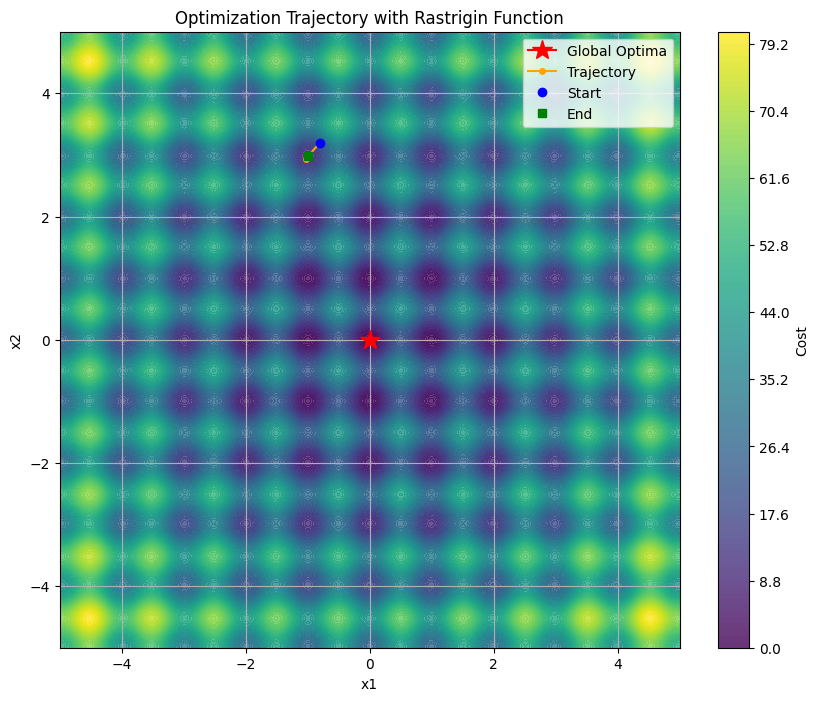

In [6]:
# Rastrigin cost + newton solver
opt = UnconstrOptimizer()
opt.set_objective('rastrigin')
opt.solve(x_init=[-0.8, 3.2], method='newton', max_step=1000) # [-0.8, 3.2] OR [-0.2, 0.2]
opt.plot_results()

Constrained case:

key idea: 

1) lagrangian & KKT & QP (linear equality constr & linear inequality constr)
2) SQP (nonlinear inequality constr)

cost: quadratic

constr: linear / nonlinear equality / inequality constr

solver: IPOPT


In [7]:
class CasadiConstrainedOptimizer:
    def __init__(self):
        self.x = ca.MX.sym('x', 2)
        self.set_objective()
        self.eq_params = None
        self.ineq_params = None
        self.optimum = None

    def set_objective(self):
        self.expr = 0.5 * (self.x[0]**2 / 4 + self.x[1]**2)
        self.f = ca.Function('f', [self.x], [self.expr])
        self.global_minima = np.array([0.0, 0.0])

    def set_constraints(self, eq_params=None, ineq_params=None):
        self.eq_params = eq_params
        self.ineq_params = ineq_params

    def solve(self, x_init=[0.0, 0.0]):
        H = ca.hessian(self.expr, self.x)[0]
        g = ca.gradient(self.expr, self.x)

        H_func = ca.Function("H_func", [self.x], [H])
        g_func = ca.Function("g_func", [self.x], [g])

        H_val = H_func(x_init).full()
        g_val = g_func(x_init).full().flatten()

        A_list = []
        lba = []
        uba = []

        if self.eq_params:
            a, b, c = self.eq_params
            A_list.append(np.array([[a, b]]))
            lba.append(-c)
            uba.append(-c)

        if self.ineq_params:
            a, b, c = self.ineq_params
            A_list.append(np.array([[a, b]]))
            lba.append(-np.inf)
            uba.append(-c)

        A_total = np.vstack(A_list) if A_list else np.zeros((0, 2))
        lba = np.array(lba)
        uba = np.array(uba)

        qp = {
            'x': self.x,
            'f': self.expr,
            'g': ca.mtimes(ca.DM(A_total), self.x)
        }

        solver = ca.qpsol('solver', 'qpoases', qp)
        sol = solver(lbg=lba, ubg=uba)
        self.optimum = sol['x'].full().flatten()
        return self.optimum.tolist()

    def plot_results(self):
        x_max = 2.5
        x_min = -2.5
        y_max = 2.5
        y_min = -2.5

        x = np.linspace(x_min, x_max, 400)
        y = np.linspace(y_min, y_max, 400)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = self.f(np.array([X[i, j], Y[i, j]])).full().flatten()[0]

        fig, ax = plt.subplots(figsize=(10, 8))
        CS = ax.contourf(X, Y, Z, levels=100, cmap=cm.viridis, alpha=0.8)
        plt.colorbar(CS, ax=ax, label='Cost')

        if self.eq_params:
            a, b, c = self.eq_params
            if b != 0:
                x_eq = np.linspace(x_min, x_max, 400)
                y_eq = (-a * x_eq - c) / b
                ax.plot(x_eq, y_eq, 'k--', linewidth=2, label='Equality Constraint')
            else:
                x_eq = -c / a
                ax.axvline(x_eq, color='k', linestyle='--', linewidth=2, label='Equality Constraint')

        if self.ineq_params:
            a, b, c = self.ineq_params
            if b != 0:
                x_ineq = np.linspace(x_min, x_max, 400)
                y_ineq = (-a * x_ineq - c) / b
                ax.plot(x_ineq, y_ineq, 'b-', linewidth=2, label='Inequality Constraint')
                ax.fill_between(x_ineq, y_ineq, y_max, color='blue', alpha=0.1)
            else:
                x_ineq = -c / a
                ax.axvline(x_ineq, color='b', linestyle='-', linewidth=2, label='Inequality Constraint')
                if a > 0:
                    ax.axvspan(x_min, x_ineq, color='blue', alpha=0.1)
                else:
                    ax.axvspan(x_ineq, x_max, color='blue', alpha=0.1)

        if self.optimum is not None:
            ax.plot(self.optimum[0], self.optimum[1], 'ro', markersize=10, label='Optimal Point')

        ax.plot(self.global_minima[0], self.global_minima[1], '*', color='red', markersize=15, label='Global Min')
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_xlabel('$x_0$')
        ax.set_ylabel('$x_1$')
        ax.set_title("Constrained Optimization Result (QPOASES)")
        ax.grid(True)
        ax.legend()
        plt.show()



qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.



####################   qpOASES  --  QP

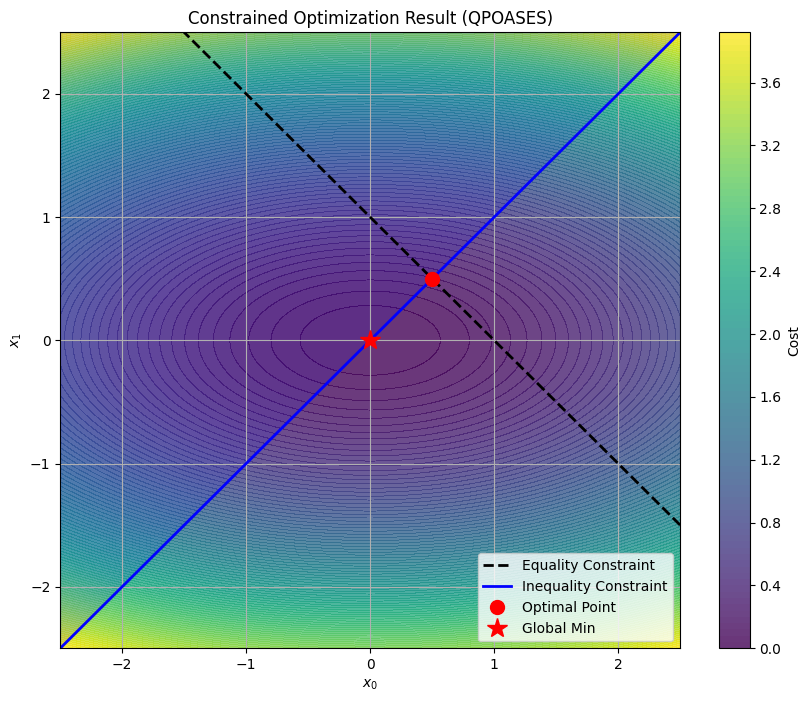

In [8]:
# qpOASES for QP
opt = CasadiConstrainedOptimizer()
opt.set_constraints(eq_params=(1, 1, -1), ineq_params=(1, -1, 0))
opt.solve(x_init=[0.5, 0.5])
opt.plot_results()




In [11]:
class SQPSolverUsingQPOases:
    def __init__(self, objective_func, eq_func=None, ineq_func=None, global_minima=None):
        self.x_sym = ca.MX.sym('x', 2)

        self.f = objective_func  # CasADi function f(x)
        self.h = eq_func         # CasADi function h(x), optional
        self.g = ineq_func       # CasADi function g(x), optional
        self.global_minima = np.array(global_minima) if global_minima is not None else None

        self.grad_f = ca.Function("grad_f", [self.x_sym], [ca.gradient(self.f(self.x_sym), self.x_sym)])
        self.hess_f = ca.Function("hess_f", [self.x_sym], [ca.hessian(self.f(self.x_sym), self.x_sym)[0]])

        if self.h:
            self.jac_h = ca.Function("jac_h", [self.x_sym], [ca.jacobian(self.h(self.x_sym), self.x_sym)])
        if self.g:
            self.jac_g = ca.Function("jac_g", [self.x_sym], [ca.jacobian(self.g(self.x_sym), self.x_sym)])

        self.trace = []

    def solve(self, x_init, tol=1e-6, max_iter=200):
        x = np.array(x_init, dtype=float)
        self.trace = []

        for iter in range(max_iter):
            # Compute cost approximations
            H = self.hess_f(x).full()
            g = self.grad_f(x).full().flatten()

            dx = ca.MX.sym("dx", 2)

            H_cas = ca.MX(H)
            g_cas = ca.MX(g)
            qp_cost = 0.5 * ca.mtimes([dx.T, H_cas, dx]) + ca.dot(g_cas, dx)

            constraints = []
            lbg = []
            ubg = []

            if self.h:
                h_val = self.h(x).full().flatten()
                jac_h = self.jac_h(x).full()
                for i in range(len(h_val)):
                    constraints.append(ca.dot(jac_h[i, :], dx) + h_val[i])
                    lbg.append(0.0)
                    ubg.append(0.0)

            if self.g:
                g_val = self.g(x).full().flatten()
                jac_g = self.jac_g(x).full()
                for i in range(len(g_val)):
                    constraints.append(ca.dot(jac_g[i, :], dx) + g_val[i])
                    lbg.append(-np.inf)
                    ubg.append(0.0)

            nlp = {
                'x': dx,
                'f': qp_cost,
                'g': ca.vertcat(*constraints) if constraints else ca.MX()
            }

            solver = ca.qpsol('solver', 'qpoases', nlp)

            sol = solver(lbg=lbg, ubg=ubg)
            dx_val = sol['x'].full().flatten()

            x_new = x + dx_val
            self.trace.append(x_new.copy())

            if np.linalg.norm(x_new - x) < tol:
                break
            x = x_new

        return x

    def plot_sqp_trajectory(self):
        """
        Plot optimization trajectory and constraint boundaries based on internal data.
        """
        x_max = 2.5
        x_min = -2.5
        y_max = 2.5
        y_min = -2.5

        x = np.linspace(x_min, x_max, 400)
        y = np.linspace(y_min, y_max, 400)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = self.f(np.array([X[i, j], Y[i, j]])).full().flatten()[0]

        fig, ax = plt.subplots(figsize=(10, 8))
        CS = ax.contourf(X, Y, Z, levels=100, cmap=cm.viridis, alpha=0.8)
        plt.colorbar(CS, ax=ax, label='Cost')

        if self.h:
            H_vals = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    H_vals[i, j] = self.h(np.array([X[i, j], Y[i, j]])).full().flatten()[0]
            ax.contour(X, Y, H_vals, levels=[0], colors='k', linewidths=2, linestyles='--', label='h(x)=0')

        if self.g:
            G_vals = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    G_vals[i, j] = self.g(np.array([X[i, j], Y[i, j]])).full().flatten()[0]
            ax.contour(X, Y, G_vals, levels=[0], colors='b', linewidths=2)
            ax.contourf(X, Y, G_vals, levels=[-np.inf, 0], colors='blue', alpha=0.1)

        if self.trace:
            traj = np.array(self.trace)
            ax.plot(traj[:, 0], traj[:, 1], 'o-', color='orange', label='SQP Trajectory')
            ax.plot(traj[0, 0], traj[0, 1], 'bo', label='Start')
            ax.plot(traj[-1, 0], traj[-1, 1], 'gs', label='End')

        if self.global_minima is not None:
            ax.plot(self.global_minima[0], self.global_minima[1], '*', color='red', markersize=15, label='Global Min')

        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_xlabel('$x_0$')
        ax.set_ylabel('$x_1$')
        ax.set_title("SQP Optimization Trajectory")
        ax.grid(True)
        ax.legend()
        plt.show()



qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.



####################   qpOASES  --  QP

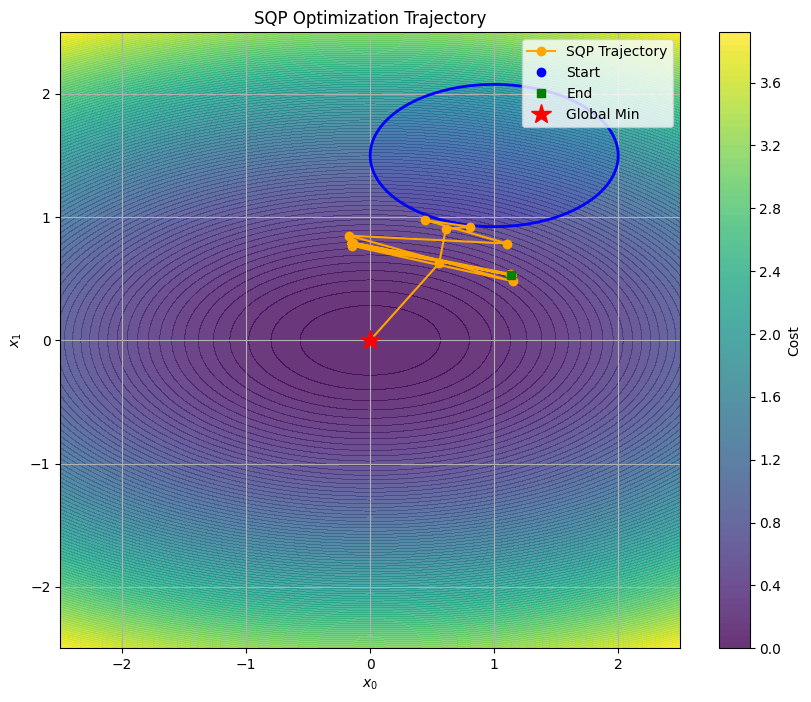

In [14]:
# 1. 定义目标函数
x = ca.MX.sym('x', 2)
f = ca.Function("f", [x], [0.5 * (x[0]**2 / 4 + x[1]**2)])

# 2. 定义约束（凸）
g = ca.Function("g", [x], [(x[0] - 1)**2 + (x[1]-1.5)**2*3 - 1])       # g(x) <= 0
h = None #ca.Function("h", [x], [x[0] + ca.sin(x[1]) - 1])           # h(x) = 0

# 创建 SQP 优化器
sqp_solver = SQPSolverUsingQPOases(
    objective_func=f,
    eq_func=h,
    ineq_func=g,
    global_minima=[0, 0]  # 这里同步传入
)

# 先求解
sol = sqp_solver.solve([1.0, 1.5])

# 再绘图
sqp_solver.plot_sqp_trajectory()

